In [1]:
import os
import PIL
from PIL import Image
from IPython.display import display

In [2]:
# common test objects
test_img = 'tests/test_images/group.jpg'

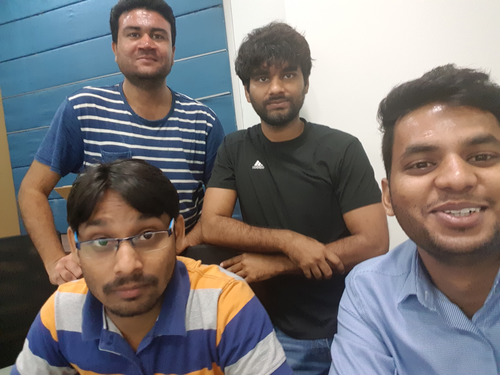

In [4]:
i = PIL.Image.open(test_img)
basewidth = 500
wpercent = (basewidth/float(i.size[0]))
hsize = int((float(i.size[1])*float(wpercent)))
display(i.resize((basewidth,hsize), PIL.Image.ANTIALIAS))

In [5]:
# test for load image
from utils import *
display(loadImage(test_img)[0:2])

ModuleNotFoundError: No module named 'face_recognition_models'

In [8]:
# test for finding face bounding boxes
print(getFaceBounds(loadImage(test_img)))

[(119, 1146, 504, 760), (1390, 1167, 2055, 502), (418, 2001, 804, 1616), (781, 3264, 1579, 2555)]


In [9]:
test_img_array = loadImage(test_img)
facePoints(test_img_array)

[{'bottom_lip': [(1029, 401),
   (1004, 407),
   (980, 409),
   (959, 409),
   (938, 405),
   (914, 398),
   (891, 391),
   (900, 390),
   (939, 384),
   (960, 388),
   (980, 389),
   (1020, 397)],
  'chin': [(759, 268),
   (759, 311),
   (760, 353),
   (766, 398),
   (780, 439),
   (812, 471),
   (857, 491),
   (906, 504),
   (957, 510),
   (1006, 508),
   (1049, 495),
   (1086, 472),
   (1111, 440),
   (1122, 400),
   (1126, 358),
   (1127, 317),
   (1125, 276)],
  'left_eye': [(843, 233),
   (863, 220),
   (888, 221),
   (910, 239),
   (887, 241),
   (862, 240)],
  'left_eyebrow': [(799, 206), (821, 177), (856, 166), (894, 170), (928, 184)],
  'nose_bridge': [(956, 225), (958, 249), (958, 271), (959, 296)],
  'nose_tip': [(915, 327), (936, 333), (958, 338), (979, 335), (999, 330)],
  'right_eye': [(992, 246),
   (1015, 231),
   (1039, 234),
   (1058, 250),
   (1038, 253),
   (1014, 252)],
  'right_eyebrow': [(978, 188),
   (1013, 179),
   (1050, 181),
   (1083, 197),
   (1099, 230)]

In [12]:
faceEncoded = faceEncodings(loadImage(test_img))
face_encoding_a1 = faceEncoded[0]
face_encoding_a2 = faceEncoded[1]
face_encoding_a3 = faceEncoded[2]
face_encoding_b1 = faceEncoded[3]

faces_to_compare = [
    face_encoding_a2,
    face_encoding_a3,
    face_encoding_b1,
    face_encoding_a1
]

distance_results = faceDistance(faces_to_compare, face_encoding_a1)
print(distance_results)


[0.73071823 0.59824114 0.70914743 0.        ]


In [ ]:
def train(train_dir, model_save_path=None, n_neighbors=None, knn_algo='ball_tree', verbose=False):
    """
    Trains a k-nearest neighbors classifier for face recognition.

    :param train_dir: directory that contains a sub-directory for each known person, with its name.

     (View in source code to see train_dir example tree structure)

     Structure:
        <train_dir>/
        ├── <person1>/
        │   ├── <somename1>.jpeg
        │   ├── <somename2>.jpeg
        │   ├── ...
        ├── <person2>/
        │   ├── <somename1>.jpeg
        │   └── <somename2>.jpeg
        └── ...

    :param model_save_path: (optional) path to save model on disk
    :param n_neighbors: (optional) number of neighbors to weigh in classification. Chosen automatically if not specified
    :param knn_algo: (optional) underlying data structure to support knn.default is ball_tree
    :param verbose: verbosity of training
    :return: returns knn classifier that was trained on the given data.
    """
    X = []
    y = []

    # Loop through each person in the training set
    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue

        # Loop through each training image for the current person
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                # If there are no people (or too many people) in a training image, skip the image.
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                # Add face encoding for current image to the training set
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)

    # Determine how many neighbors to use for weighting in the KNN classifier
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)

    # Create and train the KNN classifier
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    # Save the trained KNN classifier
    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return knn_clf
